In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import models
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
learning_rate = 0.01

In [3]:
train_transform = transforms.Compose([
                    transforms.Resize((224, 224)), 
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.ToTensor(), 
                    transforms.Normalize([0.5]*3, [0.5]*3)
]) # train transform

test_transform = transforms.Compose([
                    transforms.Resize((224, 224)), 
                    transforms.ToTensor(), 
                    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
from torch.utils.data import SubsetRandomSampler
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../datasets/cifar10/',
                                             train=True, 
                                             transform=train_transform,
                                             download=False)
valid_dataset = torchvision.datasets.CIFAR10(root='../datasets/cifar10/',
                                             train=True, 
                                             transform=test_transform,
                                             download=False)

test_dataset = torchvision.datasets.CIFAR10(root='../datasets/cifar10/',
                                            train=False, 
                                            transform=test_transform)
valid_size = 0.1
random_seed = 42

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_data_size = len(train_sampler)
valid_data_size = len(valid_sampler)
# train_dataset, valid_dataset = torch.utils.data.random_split(train,[45000,5000])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           sampler=train_sampler,
                                           num_workers = 4,
                                           pin_memory = True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=50, 
                                           sampler=valid_sampler,
                                           num_workers = 4,
                                           pin_memory = True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)


In [5]:
train_size = len(train_dataset)
valid_size = len(valid_dataset)
test_size = len(test_dataset)

print(f"[INFO]: Number of training images: {train_data_size}")
print(f"[INFO]: Number of valid images: {valid_data_size}")
print(f"[INFO]: Number of test images: {test_size}")
print(f"[INFO]: Class names: {train_dataset.classes}\n")      

[INFO]: Number of training images: 45000
[INFO]: Number of valid images: 5000
[INFO]: Number of test images: 10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


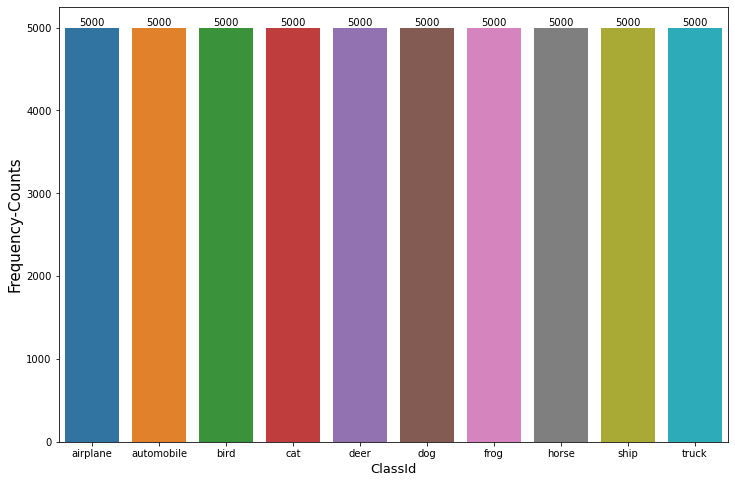

In [6]:
freq = []
epc = []
idx_to_class = list(train_dataset.classes)

for x in range (10):
    count = 0
    
    for img_class in train_dataset.targets:
        if img_class == x:
            count += 1
    epc.append(x)
    freq.append(count)

print(freq)

plt.figure(figsize=(12,8))
ax = sns.barplot(x=idx_to_class, y=freq)
ax.bar_label(ax.containers[0])
plt.ylabel('Frequency-Counts', fontsize=15)
plt.xlabel('ClassId',fontsize=13)
plt.show()


Visualize data by batches

In [7]:
train_batch1_dataset = torchvision.datasets.CIFAR10_batch1(root='../datasets/cifar10/',
                                             train=True, 
                                             transform=train_transform,
                                             download=False)
for x in range (10):
    count = 0
    
    for img_class in train_batch1_dataset.targets:
        if img_class == x:
            count += 1
    freq.append(count)

print(freq)

AttributeError: module 'torchvision.datasets' has no attribute 'CIFAR10_batch1'

In [6]:
# load pretrain model and modify...
model = models.resnet18(pretrained=True)
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

c:\Users\65913\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\65913\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 # Learning Rate Scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)


In [8]:
training_loss = []
validation_loss = []
training_accuracy = []
valid_accuracy = []
save_path = '../outputs/cifar10'

# Train the model
def train(current_epoch, num_epoch, model):
    current_loss = 0.0
    current_corrects = 0
    losses = []
    model.train()

    loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # update lr here if using stepLR
    # scheduler.step()

    epoch_accuracy = int(current_corrects / len(train_loader.dataset) * 100)
    epoch_losses =  current_loss / len(train_loader.dataset)
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    # save learning rate
    # learning_rate.append(scheduler.optimizer.param_groups[0]['lr'])
    
    # save model
    torch.save({ 
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                }, os.path.join(save_path,'checpoint_epoch_'+str(current_epoch)+'.pt'))


        
# model.eval() is a kind of switch for some specific layers/parts of the model that behave differently,
# during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
# You need to turn off them during model evaluation, and .eval() will do it for you. In addition, 
# the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() 
# to turn off gradients computation:
        
def test():
    model.eval()
    test_loss = 0
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)
            current_loss += test_loss.item() * x.size(0)
            
    epoch_loss = current_loss / valid_data_size
    validation_loss.append(epoch_loss)
    valid_accuracy.append(correct / valid_data_size * 100)

    print("Average Loss: ", epoch_loss, "  Accuracy: ", correct, " / ",
    valid_data_size, "  ", correct / valid_data_size * 100, "%")


def train_model(num_epoch, model):
    for epoch in range(0, num_epoch):
        train(epoch, num_epoch, model)
        test()

In [9]:
train_model(10, model)

Epoch 1/10 process: 99: 100%|██████████| 450/450 [00:30<00:00, 14.95it/s, loss=0.875]


Average Loss:  0.6745548798143863   Accuracy:  3876  /  5000    77.52 %


Epoch 2/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 18.98it/s, loss=0.888]


Average Loss:  0.6778164279460906   Accuracy:  3920  /  5000    78.4 %


Epoch 3/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 18.86it/s, loss=0.778]


Average Loss:  0.7435281622409821   Accuracy:  3865  /  5000    77.3 %


Epoch 4/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 19.09it/s, loss=1.03] 


Average Loss:  0.7153401973843575   Accuracy:  3893  /  5000    77.86 %


Epoch 5/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 19.31it/s, loss=0.939]


Average Loss:  0.8394090494513512   Accuracy:  3794  /  5000    75.88000000000001 %


Epoch 6/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 19.08it/s, loss=0.736]


Average Loss:  0.6917229491472244   Accuracy:  3977  /  5000    79.54 %


Epoch 7/10 process: 99: 100%|██████████| 450/450 [00:24<00:00, 18.72it/s, loss=1.02] 


Average Loss:  0.6815323935449124   Accuracy:  3943  /  5000    78.86 %


Epoch 8/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 19.26it/s, loss=0.878]


Average Loss:  0.731841898560524   Accuracy:  3924  /  5000    78.48 %


Epoch 9/10 process: 99: 100%|██████████| 450/450 [00:24<00:00, 18.68it/s, loss=0.616]


Average Loss:  0.704030894935131   Accuracy:  3959  /  5000    79.17999999999999 %


Epoch 10/10 process: 99: 100%|██████████| 450/450 [00:23<00:00, 18.99it/s, loss=0.758]


Average Loss:  0.6990569055080413   Accuracy:  3935  /  5000    78.7 %


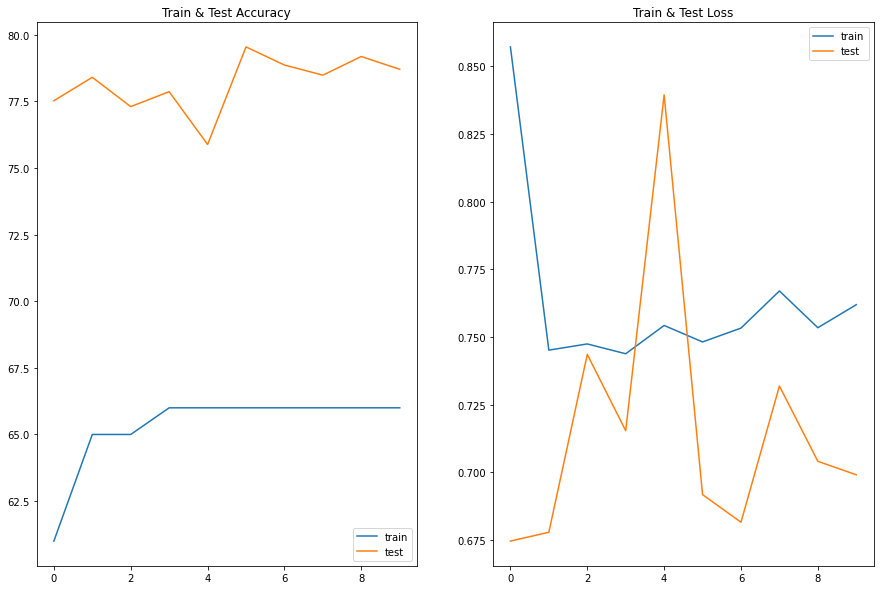

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(epc, training_accuracy,label='train')
axs[0].plot(epc, valid_accuracy,label='test')
axs[0].legend(loc='lower right')
axs[1].set_title('Train & Test Loss')
axs[1].plot(epc, training_loss,label='train')
axs[1].plot(epc, validation_loss,label='test')
axs[1].legend(loc='upper right')

In [11]:
print("----> Loading checkpoint")
checkpoint = torch.load("../outputs/cifar10/checpoint_epoch_9.pt") # Try to load last checkpoint
model.load_state_dict(checkpoint["model_state_dict"]) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

----> Loading checkpoint


In [12]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 78.4 %
